### PPMI implementation

In [48]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import pickle

from sklearn.model_selection import train_test_split
from utils.data import load_PPMI_data
from collections import ChainMap

import multiprocessing
from functools import partial

import utils.preprocess

import data_utils as du
from PPMI_dataloader import *

data_dir = du.find_data_dir('app')
metapaths_metabolites_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'PPMI_neighbor_pairs.p')

### Use Dataloader class

In [2]:
calc_CCS_settings = {'method': 'naive', 
                     'p_value': 0.1}

allowed_ccs_values = [-1, 0, 1]

include_feature_protein = {'molecular_function': True,
                           'biological_process': True,
                           'protein_class': True}

include_feature_metabolite = {'molecular_weight': True,
                            'state': True,
                            'kingdom': True,
                            'super_class': True,
                            'class': False,
                            'direct_parent': False,
                            'molecular_framework': True,
                            'alternative_parents': True,
                            'substituents': True,
                            'external_descriptors': False,
                            'cellular_locations': True,
                            'biospecimen_locations': True,
                            'tissue_locations': True,
                            'pathways': False}

include_feature_category = {'metabolite': include_feature_metabolite,
                            'protein': include_feature_protein}

metabolite_matcher_file = du.get_file_path(data_dir, 'class based structure', 'metabolite matching', 'matcher.p')
dataloader = DataLoader(include_feature_category, metabolite_matcher_file=metabolite_matcher_file, calc_CCS_settings=calc_CCS_settings, allowed_ccs_values=allowed_ccs_values)
dataloader.save_state()
dataloader.print_data_counts()

Number of metabolites in publication Millan 2020: 368
Number of unnamed metabolites in publication Millan 2020: 14
Number of metabolites in publication Millan 2020 after removing unnamed: 354
Number of metabolites with KEGG id, without HMDB id: 29
Number of metabolites with HMDB id and data: 325
Number of unique duplicated HMDB ids: 9
Number of removed rows becuase target value was not allowed: 0
Total number of metabolites in full PPMI: 20759
Total number of metabolites with CCS and not in PPMI: 82
Number of metabolites with CCS data in full PPMI: 261

Number of valid metabolites with CCS data in full PPMI (y): 228
Number of metabolite feature columns (X): 255


In [3]:
dataloader.target_distribution_stats()

,Amount,Percentage
-1,91,39.9%
0,70,30.7%
1,67,29.4%
Total,228,100.0%


In [164]:
colnames = pd.Series(list(dataloader.protein_features.columns))
mol_func_bool = pd.Series(['Molecular function' in colname for colname in colnames])
bio_proc_bool = pd.Series(['Biological process' in colname for colname in colnames])
prot_class_bool = pd.Series(['Protein class' in colname for colname in colnames])

print('Columns Molecular function: ', len(colnames[mol_func_bool]), '/ 130')
print('Columns Biological process: ', len(colnames[bio_proc_bool]), '/ 233')
print('Columns Protein class: ', len(colnames[prot_class_bool]), '/ 21')

Columns Molecular function:  112 / 130
Columns Biological process:  188 / 233
Columns Protein class:  21 / 21


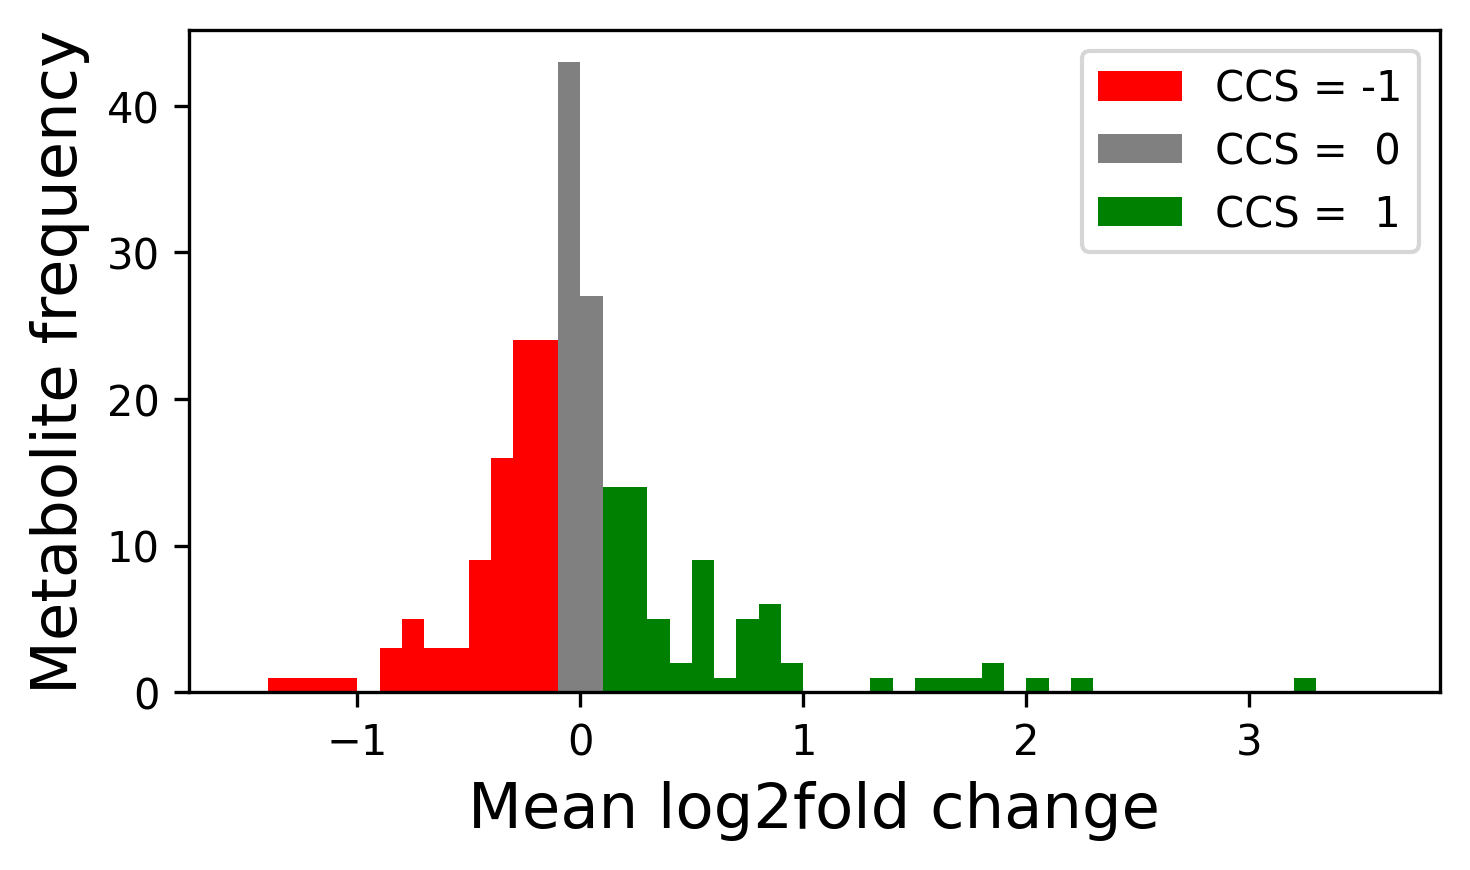

In [109]:
def plot_meanlog2foldchange_histogram(dataloader, save_fig=False):
    fig = plt.figure(figsize=(5,3), dpi=300)
    fig.patch.set_facecolor('white')   
    
    # Get mean log2fold_change based of CCS value
    delta_equal = dataloader.hmdb_log2fold_change_CSS[dataloader.hmdb_log2fold_change_CSS['CCS'] == 0]['log2foldchange']
    delta_up = dataloader.hmdb_log2fold_change_CSS[dataloader.hmdb_log2fold_change_CSS['CCS'] == 1]['log2foldchange']
    delta_down = dataloader.hmdb_log2fold_change_CSS[dataloader.hmdb_log2fold_change_CSS['CCS'] == -1]['log2foldchange']
    
    # Determine equal bin sizes
    xmin = -1.5
    xmax = 3.7
    stepsize = .1
#     total = (xmax-xmin)/stepsize
    bins_down = np.arange(xmin, 0, stepsize)
    bins_equal = np.arange(-0.1, 0.1999, stepsize)
    bins_up = np.arange(0.1, xmax, stepsize)
    bins_all = np.arange(xmin, xmax, stepsize)    
    
    # Plot histogram per CCS category
    plt.hist(delta_down, color='red', bins=bins_down, label='CCS = -1')
    plt.hist(delta_equal, color='gray', bins=bins_equal, label='CCS =  0')
    plt.hist(delta_up, color='green', bins=bins_up, label='CCS =  1')
    plt.legend()
    
    plt.xlabel('Mean log2fold change', fontsize=15)
    plt.ylabel('Metabolite frequency', fontsize=15)
    plt.tight_layout()
    if save_fig:            
        filename = f'sportomics--histogram--log2foldchange.png'
        plt.savefig(Path('Figures', filename), bbox_inches='tight')
    plt.show()

plot_meanlog2foldchange_histogram(dataloader, True)

In [135]:
#Testing for normality of hmdb_log2fold_change_CSS['log2foldchange']
#There is still a single NaN value in the array to be removed

from scipy.stats import normaltest
from scipy.stats import shapiro
array = dataloader.hmdb_log2fold_change_CSS['log2foldchange'][dataloader.hmdb_log2fold_change_CSS['log2foldchange'].notna()]
normaltest(array, nan_policy='omit')
shapiro(array)

ShapiroResult(statistic=0.8464573621749878, pvalue=3.026792954729379e-14)

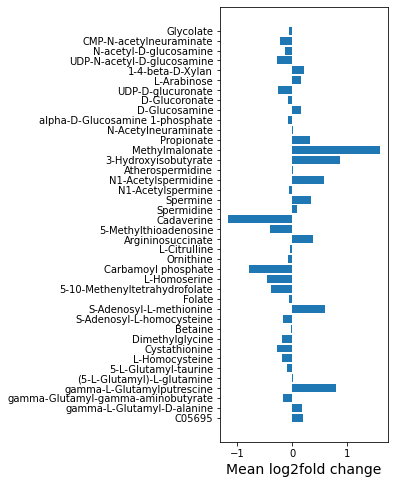

In [11]:
dataloader.millan_2020.plot_changes('Mean log2fold change', from_id=100, till_id=140, save_fig=True)

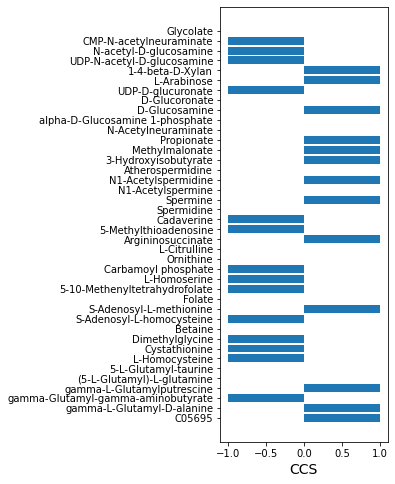

In [12]:
dataloader.millan_2020.plot_changes('CCS', from_id=100, till_id=140, save_fig=True)

In [3]:
print('UNMATCHED REMOVED PROTEINS')
dataloader.print_protein_names(dataloader.protein_nodes_gene[dataloader.protein_nodes_gene.isna()].index)

UNMATCHED REMOVED PROTEINS
'ABCF2', 'ACOT7L', 'AGAP10', 'AGAP7', 'AHSA2', 'AILE3', 'AKR1C8P', 'AKR7L', 'ALDOA', 'ANKRD26P1', 'ANKRD36BP1', 'ANP32C', 'APOBEC3A_B', 'ARP3BETA', 'ASB16-AS1', 'ATXN7', 'B-RAF', 'BCE1', 'BCR-ABL', 'BCR/ABL', 'C10ORF10', 'C10ORF12', 'C10ORF2', 'C10ORF32', 'C10ORF35', 'C10ORF4', 'C10ORF54', 'C10ORF55', 'C10ORF62', 'C10ORF76', 'C10ORF82', 'C10ORF88', 'C10ORF90', 'C11ORF1', 'C11ORF16', 'C11ORF30', 'C11ORF31', 'C11ORF45', 'C11ORF49', 'C11ORF52', 'C11ORF53', 'C11ORF54', 'C11ORF57', 'C11ORF58', 'C11ORF63', 'C11ORF65', 'C11ORF68', 'C11ORF70', 'C11ORF71', 'C11ORF73', 'C11ORF74', 'C11ORF80', 'C11ORF84', 'C11ORF87', 'C12ORF10', 'C12ORF29', 'C12ORF4', 'C12ORF40', 'C12ORF43', 'C12ORF45', 'C12ORF49', 'C12ORF5', 'C12ORF50', 'C12ORF57', 'C12ORF60', 'C12ORF65', 'C12ORF73', 'C12ORF75', 'C12ORF76', 'C14ORF1', 'C14ORF105', 'C14ORF119', 'C14ORF142', 'C14ORF159', 'C14ORF166', 'C14ORF169', 'C14ORF178', 'C14ORF182', 'C14ORF2', 'C14ORF20', 'C14ORF80', 'C14ORF93', 'C15ORF38-AP3S2', '

In [165]:
dataloader.X.shape, dataloader.protein_features.shape

((228, 255), (11924, 321))

### Save MetaboliteMatcher object

In [4]:
matcher = dataloader.metabolite_matcher
metabolite_matcher_file = du.get_file_path(data_dir, 'class based structure', 'metabolite matching', 'matcher.p')
du.dump_in_pickle(metabolite_matcher_file, matcher)

### Load saved Dataloader object

In [2]:
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

### MAGNN preprocessing

In [167]:
def get_CCS_class(CCS, CCS_classes):
    return CCS_classes[CCS]

CCS_classes = {-1: 'down',
                0: 'unchanged',
                1: 'up'}

CCS_labels_binary = {'down': 0,
                     'up': 1}

CCS_labels_multi_class = {'down': 0,
                          'unchanged': 1,
                          'up': 2}

types = {'metabolite': 0,
         'protein': 1}

classes = dataloader.y.apply(get_CCS_class, args=(CCS_classes,))
multi_class_labels = classes.apply(get_CCS_class, args=(CCS_labels_multi_class,))

MPM_metapath = (types['metabolite'], types['protein'], types['metabolite'])
MPPM_metapath = (types['metabolite'], types['protein'], types['protein'], types['metabolite'])

PPMI_expected_metapaths = [
    [MPM_metapath, MPPM_metapath], #metabolite metapaths
    [] #protein metapaths
]

PPMI_type_mask = np.array([types['metabolite'] if 'HMDB' in node else types['protein'] for node in dataloader.PPMI_pruned.nodes()], dtype='int32')
n_proteins = pd.Series(PPMI_type_mask).value_counts()[types['protein']]
n_metabolites = pd.Series(PPMI_type_mask).value_counts()[types['metabolite']]

#0 for down and 1 for up (binary case)
#0 for down and 1 for unchanged and 2 for up (multi class case)
PPMI_labels = multi_class_labels

PPMI_adjM = nx.convert_matrix.to_numpy_array(dataloader.PPMI_pruned)

adjM_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'adjM.npz')
features_proteins_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'features_proteins.npz')
features_metabolites_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'features_metabolites.npz')
node_types_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'node_types.npy')
labels_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'labels.npy')

scipy.sparse.save_npz(adjM_file, scipy.sparse.csr_matrix(PPMI_adjM))
scipy.sparse.save_npz(features_proteins_file, scipy.sparse.csr_matrix(dataloader.protein_features))
scipy.sparse.save_npz(features_metabolites_file, scipy.sparse.csr_matrix(dataloader.X))
np.save(node_types_file, PPMI_type_mask)
np.save(labels_file, PPMI_labels)

#### getting metapath instances

In [87]:
def get_metapath_neighbor_pairs_PPMI(M, type_mask, metapaths):
    outputs = []
    for metapath in metapaths:
        print('Getting neighbor pairs for ', metapath)
        # consider only the edges relevant to the expected metapath
        mask = np.zeros(M.shape, dtype=bool)
        for i in range(len(metapath)-1):
            temp = np.zeros(M.shape, dtype=bool)
            temp[np.ix_(type_mask == metapath[i], type_mask == metapath[i + 1])] = True
            temp[np.ix_(type_mask == metapath[i + 1], type_mask == metapath[i])] = True
            mask = np.logical_or(mask, temp)
        partial_g_nx = nx.from_numpy_matrix((M * mask).astype(int))
        
        metapath_neighbor_paris = {}
        for source in (type_mask == metapath[0]).nonzero()[0]:
            if source == 0 or source % 5 == 0:            
                print('  Node', source)
            for target in (type_mask == metapath[-1]).nonzero()[0]:
                has_path = False
                single_source_paths = nx.single_source_shortest_path(
                    partial_g_nx, source, cutoff=len(metapath))
                if target in single_source_paths:
                    has_path = True

                if has_path:
                    shortests = [p for p in nx.all_shortest_paths(partial_g_nx, source, target) if
                                 len(p) == len(metapath)]
                    if len(shortests) > 0:
                        metapath_neighbor_paris[(source, target)] = shortests       
        
        outputs.append(metapath_neighbor_paris)
    return outputs

def find_metapaths_from_source(metapath, type_mask, partial_g_nx, source):
    metapath_neighbor_pairs_source = {}
#     if source == 0 or source % 5 == 0:            
    print(f'  Node {source}', )
    for target in (type_mask == metapath[-1]).nonzero()[0]:
        has_path = False
        single_source_paths = nx.single_source_shortest_path(
            partial_g_nx, source, cutoff=len(metapath))
        if target in single_source_paths:
            has_path = True

        if has_path:
            shortests = [p for p in nx.all_shortest_paths(partial_g_nx, source, target) if
                         len(p) == len(metapath)]
            if len(shortests) > 0:
                metapath_neighbor_pairs_source[(source, target)] = shortests       
    return metapath_neighbor_pairs_source

def get_metapath_neighbor_pairs_PPMI_MP(M, type_mask, metapaths):
    outputs = []
    for metapath in metapaths:
        print('Getting neighbor pairs for ', metapath)
        # consider only the edges relevant to the expected metapath
        mask = np.zeros(M.shape, dtype=bool)
        for i in range(len(metapath)-1):
            temp = np.zeros(M.shape, dtype=bool)
            temp[np.ix_(type_mask == metapath[i], type_mask == metapath[i + 1])] = True
            temp[np.ix_(type_mask == metapath[i + 1], type_mask == metapath[i])] = True
            mask = np.logical_or(mask, temp)
        partial_g_nx = nx.from_numpy_matrix((M * mask).astype(int))
        
        metapath_neighbor_paris = {}
        a_pool = multiprocessing.Pool()
        func = partial(find_metapaths_from_source, metapath, type_mask, partial_g_nx)
        result = a_pool.map(func, (type_mask == metapath[0]).nonzero()[0])  
        a_pool.close()
        a_pool.join()
        metapath_neighbor_paris = dict(ChainMap(*result))
        
        outputs.append(metapath_neighbor_paris)
    return outputs

def get_node_names(i_nodes):
    node_names = list(PPMI_pruned.nodes)
    return [node_names[i_node] for i_node in i_nodes]

In [88]:
type_i = 'metabolite'
PPMI_neighbor_pairs = get_metapath_neighbor_pairs_PPMI_MP(PPMI_adjM, PPMI_type_mask, PPMI_expected_metapaths[types[type_i]])
du.dump_in_pickle(metapaths_metabolites_file, PPMI_neighbor_pairs)
G_list = utils.preprocess.get_networkx_graph(PPMI_neighbor_pairs, PPMI_type_mask, types[type_i])
for G, metapath in zip(G_list, PPMI_expected_metapaths[types[type_i]]):
    filename = 'metapath_graph_' + '-'.join(map(str, metapath)) + '.adjlist'
    metapaths_metabolites_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', filename)
    nx.write_adjlist(G, metapaths_metabolites_file)
all_edge_metapath_idx_array = utils.preprocess.get_edge_metapath_idx_array(PPMI_neighbor_pairs)
for metapath, edge_metapath_idx_array in zip(PPMI_expected_metapaths[types[type_i]], all_edge_metapath_idx_array):
    filename = 'edges_' + '-'.join(map(str, metapath)) + '_idx.npy'
    edges_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', filename)
    np.save(edges_file, edge_metapath_idx_array)

Getting neighbor pairs for  (0, 1, 0)
  Node 0
  Node 8
  Node 16
  Node 24
  Node 32
  Node 40
  Node 48  Node 56

  Node 49
  Node 25
  Node 17
  Node 1
  Node 33
  Node 34
  Node 35
  Node 9
  Node 50
  Node 18
  Node 2
  Node 41
  Node 19
  Node 57
  Node 26
  Node 3
  Node 10
  Node 42
  Node 51
  Node 36
  Node 43
  Node 11
  Node 27
  Node 52
  Node 4
  Node 44
  Node 53
  Node 58
  Node 37
  Node 28
  Node 45
  Node 29
  Node 5
  Node 20
  Node 12
  Node 30
  Node 38
  Node 59
  Node 6
  Node 46
  Node 31
  Node 47
  Node 54
  Node 13  Node 39

  Node 64
  Node 21
  Node 72
  Node 7
  Node 60
  Node 14
  Node 80
  Node 81
  Node 82
  Node 55
  Node 15
  Node 65
  Node 61
  Node 83
  Node 73
  Node 88
  Node 74
  Node 66
  Node 84
  Node 67  Node 62

  Node 68
  Node 89
  Node 90
  Node 69
  Node 96
  Node 70
  Node 91
  Node 92
  Node 63
  Node 85
  Node 93
  Node 22
  Node 86
  Node 71
  Node 104
  Node 97
  Node 105
  Node 94
  Node 23
  Node 87
  Node 112
  Node 98
  Node 75

In [89]:
target_idx_list = np.arange(len(PPMI_labels))
for metapath in PPMI_expected_metapaths[types[type_i]]:
    filename = 'edges_' + '-'.join(map(str, metapath)) + '_idx.npy'
    edges_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', filename)
    edge_metapath_idx_array = np.load(edges_file)
    target_metapaths_mapping = {}
    for target_idx in target_idx_list:
        target_metapaths_mapping[target_idx] = edge_metapath_idx_array[edge_metapath_idx_array[:, 0] == target_idx][:, ::-1]
    filename_new = 'edges_' + '-'.join(map(str, metapath)) + '_idx.pickle'
    edges_file_new = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', filename_new)
    du.dump_in_pickle(edges_file_new, target_metapaths_mapping)

#### Creating train-val-test split

In [175]:
def train_val_test_stats(PPMI_labels, train_idx, val_idx, test_idx):
    n_samples = len(PPMI_labels)
    df = pd.DataFrame([['Train', len(train_idx), len(train_idx)/n_samples*100], 
    ['Val', len(val_idx), len(val_idx)/n_samples*100],
    ['Test', len(test_idx), len(test_idx)/n_samples*100]], columns = ['Group', 'Size', '%']).set_index('Group').style.format({'Size': "{:.0f}", "%": "{:.1f}%"})
    df.index.name = None
    return df  

val_train_test_idx_file = du.get_file_path(data_dir, 'MAGNN', 'preprocessed', 'val_train_test_idx.npz')

rand_seed = 1566911444
train_idx, test_idx = train_test_split(np.arange(len(PPMI_labels)), test_size=.6, random_state=rand_seed)
train_idx, val_idx = train_test_split(train_idx, test_size=.4, random_state=rand_seed)
train_idx.sort()
val_idx.sort()
test_idx.sort()

np.savez(val_train_test_idx_file,
         val_idx=val_idx,
         train_idx=train_idx,
         test_idx=test_idx)

train_val_test_stats(PPMI_labels, train_idx, val_idx, test_idx)

,Size,%
Train,54,23.7%
Val,37,16.2%
Test,137,60.1%


### Experimentation

In [18]:
PPMI_neighbor_pairs[1]

{(0, 20): [[0, 218, 268, 20],
  [0, 220, 268, 20],
  [0, 218, 274, 20],
  [0, 218, 277, 20],
  [0, 220, 277, 20],
  [0, 218, 279, 20],
  [0, 220, 309, 20],
  [0, 260, 309, 20],
  [0, 223, 338, 20],
  [0, 238, 338, 20],
  [0, 223, 343, 20],
  [0, 223, 349, 20],
  [0, 238, 349, 20],
  [0, 234, 375, 20],
  [0, 238, 396, 20],
  [0, 256, 418, 20],
  [0, 256, 430, 20],
  [0, 259, 455, 20],
  [0, 259, 457, 20]],
 (0, 25): [[0, 218, 270, 25],
  [0, 218, 282, 25],
  [0, 220, 282, 25],
  [0, 260, 282, 25],
  [0, 220, 307, 25],
  [0, 223, 348, 25],
  [0, 256, 441, 25],
  [0, 256, 442, 25],
  [0, 259, 456, 25],
  [0, 260, 464, 25],
  [0, 260, 465, 25]],
 (0, 26): [[0, 218, 270, 26], [0, 259, 456, 26], [0, 260, 465, 26]],
 (0, 27): [[0, 259, 456, 27], [0, 260, 465, 27]],
 (0, 28): [[0, 218, 293, 28]],
 (0, 40): [[0, 218, 270, 40]],
 (0, 43): [[0, 218, 293, 43]],
 (0, 47): [[0, 218, 289, 47],
  [0, 220, 289, 47],
  [0, 218, 295, 47],
  [0, 221, 326, 47],
  [0, 237, 383, 47],
  [0, 256, 451, 47]],
 (